In [164]:
import os
os.chdir("/usr/src/app")
import pandas as pd
from os.path import join as jp
import cv2
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import re

In [230]:
# Path videos
PATH_VIDEOS_DATASET = "videos/tennistv"
PATH_IMAGES_DATASET = "images/tennistv"
PATH_IMAGES_REFCOURT = jp(PATH_IMAGES_DATASET, "ref_court")

# Path master
PATH_MASTER = "deepsetstats/dataset/tennistv/parquet/master.parquet"

# Path tournaments
PATH_TOURNAMENTS = "deepsetstats/dataset/tournaments/parquet/tournaments_tennistv.parquet"

# Reference videos output
PATH_REFERENCE_VIDEOS = "deepsetstats/dataset/tennistv/parquet/reference_videos.parquet"

# Functions

In [223]:
def parse_img_ref(string):
    pattern_vid = r'___v(.*?)___f'
    pattern_tourn = r'___t(.*?)___v'
    match = re.search(pattern, string)
    match_tourn = re.search(pattern_tourn, string)
    
    if match and match_tourn:
        video_id = match.group(1)
        tourn_id = match_tourn.group(1)
        return video_id, int(tourn_id)
    else:
        return None, None

In [149]:
def bgr_to_rgb(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

def rgb_to_bgr(img_rgb):
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    return img_bgr

In [150]:
def plot_img_rgb(img_rgb):

    # Plot the first frame using matplotlib
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels and ticks
    plt.show()

In [151]:
def save_bgr_img(path, img_bgr):
    cv2.imwrite(path, img_bgr)

In [152]:
def get_random_frame(video_id, frame_num_input=None):
    filename = f'{video_id}.mp4'
    path_video_id = jp(PATH_VIDEOS_DATASET, filename)
    if not os.path.exists(path_video_id):
        print(f"Warning! does not exist path: {path_video_id}")
        return False, False, 0

    # Open the video capture object
    cap = cv2.VideoCapture(path_video_id)
    
    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_num_input is None:
        # Select a random frame
        random_frame_index = random.randint(0, total_frames - 1)
    else:
        random_frame_index = frame_num_input
    
    # Set the frame position to the random index
    cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame_index)
    
    # Read the frame at the random index
    ret, frame_bgr = cap.read()
    
    # Convert the frame from BGR to RGB
    frame_rgb = bgr_to_rgb(frame_bgr)
    
    # Plot the first frame using matplotlib
    plot_img_rgb(frame_rgb)

    
    return frame_bgr, True, random_frame_index

In [21]:
def list_videos(path):
    extension = ".mp4"
    l_videos_downloaded = os.listdir(path)

    # Set of already downloaded videos
    s_videos_downloaded = set()
    
    for vid in l_videos_downloaded:
        if vid.endswith(extension):
            vid_id = vid.split(extension)[0]
            s_videos_downloaded.add(vid_id)
    return s_videos_downloaded

# Get Downloaded Videos Id

In [25]:
sv = list_videos(PATH_VIDEOS_DATASET)
print("Videos downloaded:", len(sv))

Videos downloaded: 469


# Load Master table

In [211]:
df = pd.read_parquet(PATH_MASTER, engine="pyarrow")
df_tt = pd.read_parquet(PATH_TOURNAMENTS, engine="pyarrow")

In [212]:
df_data = df[df["video_id"].isin(sv)].copy()
df_data = pd.merge(df_data, df_tt[["tournament_name", "level"]].drop_duplicates(), on=["tournament_name"], how="left")

In [213]:
df_data.groupby(["tournament_name", "level"])["video_id"].count().reset_index().sort_values("level", ascending=False).head(120)

,tournament_name,level,video_id
0,ATP Finals,finals,6
8,Dubai,500,10
28,Queen's,500,48
1,Acapulco,500,10
14,Hamburg,500,36
13,Halle,500,47
35,Washington,500,49
5,Basel,500,2
4,Barcelona,500,52
21,Mallorca,250,30


# Select one video Id per tournament

In [214]:
court_reference_videos = df_data.groupby(["tournament_name", "level"])["video_id"].first().reset_index()
court_reference_videos = court_reference_videos.sort_values("level")

In [215]:
cols = ["tournament_name", "tournament_id",]
court_reference_videos = pd.merge(
    court_reference_videos,
    df_tt[cols].drop_duplicates(),
    on = cols[0],
    how="left"
)

In [217]:
# Save the selected reference videos
court_reference_videos.to_parquet(PATH_REFERENCE_VIDEOS, engine="pyarrow")

# Select reference court frame

Select a frame in which the court of that tournament can be clearly seen

In [231]:
# Already existing tournaments in the reference
l_existing_ref = os.listdir(PATH_IMAGES_REFCOURT)

existing_tournament_ids_ref = set()
existing_video_ids_ref = set()
for name_imref in l_existing_ref:
    if name_imref.endswith(".png"):
        vid_id, tour_id = parse_img_ref(name_imref)
        existing_video_ids_ref.add(vid_id)
        existing_tournament_ids_ref.add(tour_id)

In [229]:
skipped_vids = set()

# Selector of the best reference court images
for i,row in court_reference_videos.iterrows():
    tournament_id = row["tournament_id"]
    video_id = row["video_id"]
    tour_name = row["tournament_name"]
    level = row["level"]

    if tournament_id in existing_tournament_ids_ref:
        print(f"Tournament: {tour_name}, already done, next one please!")
        continue
        
    if video_id in existing_video_ids_ref:
        print(f"Video: {video_id}, already done, next one please!")
        continue

    while True:
        print("==" * 30)
        print(f"Tournament: {tour_name}")
        print("==" * 30)
        img_bgr, frame_ok, frame_num = get_random_frame(video_id)
        user_input = input(f"Do you want to save? (y/n/s(skip): ")
        clear_output(wait=True)
        time.sleep(0.2)
        
        if user_input.lower() == "y":
            # Save the image and break the while loop to go to the next
            name_img = f"ref___l{level}___t{tournament_id}___v{video_id}___f{frame_num}.png"
            path_img_ref = jp(PATH_IMAGES_REFCOURT, name_img)
            save_bgr_img(path=path_img_ref, img_bgr=img_bgr)
            print(f"Saved image: {name_img}")
            break
        elif user_input.lower() == "s":
            print(f"Skipping video")
            skipped_vids.add(video_id)
            break
        else:
            print("Not saving ! Generating a new image")
            time.sleep(0.5)
            clear_output(wait=True)
            continue

Saved image: ref___lfinals___t64___vdsALS4dDxDs___f12418.png


In [105]:
tournament_id

8

In [97]:
video_id

'RlUN-rG0w9w'

In [98]:
tour_name

'Rome'

In [99]:
level

'1000'

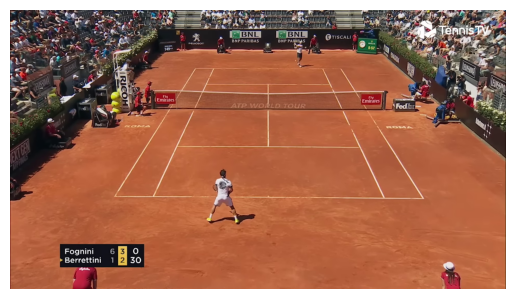

In [153]:
img_bgr, frame_ok, frame_num = get_random_frame(video_id, frame_num)

In [155]:
ok_to_save = True
if ok_to_save:
    name_img = f"ref___t{tournament_id}___v{video_id}___f{frame_num}.png"
    path_img_ref = jp(PATH_IMAGES_DATASET, name_img)
    save_bgr_img(path=path_img_ref, img_bgr=img_bgr)
    print(f"Saved image: {name_img}")
else:
    print("Not saving image")

Saved image: ref___t8___vRlUN-rG0w9w___f19842.png


True